In [1]:
# load module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import wntr
import wntr_utils
from sklearn.preprocessing import MinMaxScaler
from random import shuffle
import csv
import random

In [2]:
# load STREaM data (STREaM is a simulator of end-uses and water demand patterns)
# This dataset contains 3 years of hourly (26280 data points) synthetic demand data 
# for 4 user_classes = ['low','average','high','morning','night']. There are 500 user for each class,
# with the first 10 users having leaks. We need to remove these users for our purposes. 

all_data_path = './data/allData.txt'
df = pd.read_csv(all_data_path, header=None)

# create headers
user_classes = ['low','average','high','morning','night']
headers = []
for user_class in user_classes:
    suffixes = (('_'+user_class+' ')*400).split() # original
    for suffix, number in zip(suffixes,range(1,401)):
        headers.append('user'+suffix+'_'+'%03d'%number)  
        
# reverse df and change df columns
df = df.T
df.columns = headers

# remove first 10 of each class (these have leaks, so not useful for our purposes)
users_to_remove = np.array(headers).reshape(-1,10)[::40].ravel().tolist()
df.drop(users_to_remove, axis = 1, inplace = True)
headers = df.columns

In [3]:
# this function creates a hourly pattern of multipliers (up to 26280 hours long) mixing together n (max 1950) patterns
# from the STREaM dataset; it scales within a range (as expected for WNTR/EPANET input)
def create_demand_pattern(df_patterns, n_hours=168, n_mix=50, bound = [0.3,0.9], noise_intensity=0.01):
    cols =df_patterns.columns.to_list()
    shuffle(cols)
    df_patterns = df_patterns[cols]
    s = MinMaxScaler(bound)
    temp=np.squeeze(s.fit_transform(df_patterns.iloc[:n_hours,:n_mix].mean(axis=1).values.reshape(-1,1)))
    dem_pat = temp + np.random.randn(n_hours)*noise_intensity
    return dem_pat

In [4]:
# load EPANET model
inp_file = 'ctown_map.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# save original patterns
names, patterns =[],[]
for name, pat in wn.patterns():
    names.append(name)
    patterns.append(pat.multipliers)
df_pat_orig = pd.DataFrame(data = patterns).T
df_pat_orig.columns = names

C:\ProgramData\Anaconda3\lib\site-packages\wntr\epanet\io.py:2085: UserWarning:

Not all curves were used in "ctown_map.inp"; added with type None, units conversion left to user



In [5]:
# Generate a 3-year pattern for the District Metered Area (DMA)
names, patterns =[],[]
for name, pat in wn.patterns():
    names.append(name)
    temp = create_demand_pattern(df, n_hours=24*365*3, n_mix=150)
    pat.multipliers = temp
    patterns.append(pat.multipliers)
df_pat_new = pd.DataFrame(data = patterns).T
df_pat_new.columns = names
df_pat_new.to_csv('three_year_demands_ctown.csv')

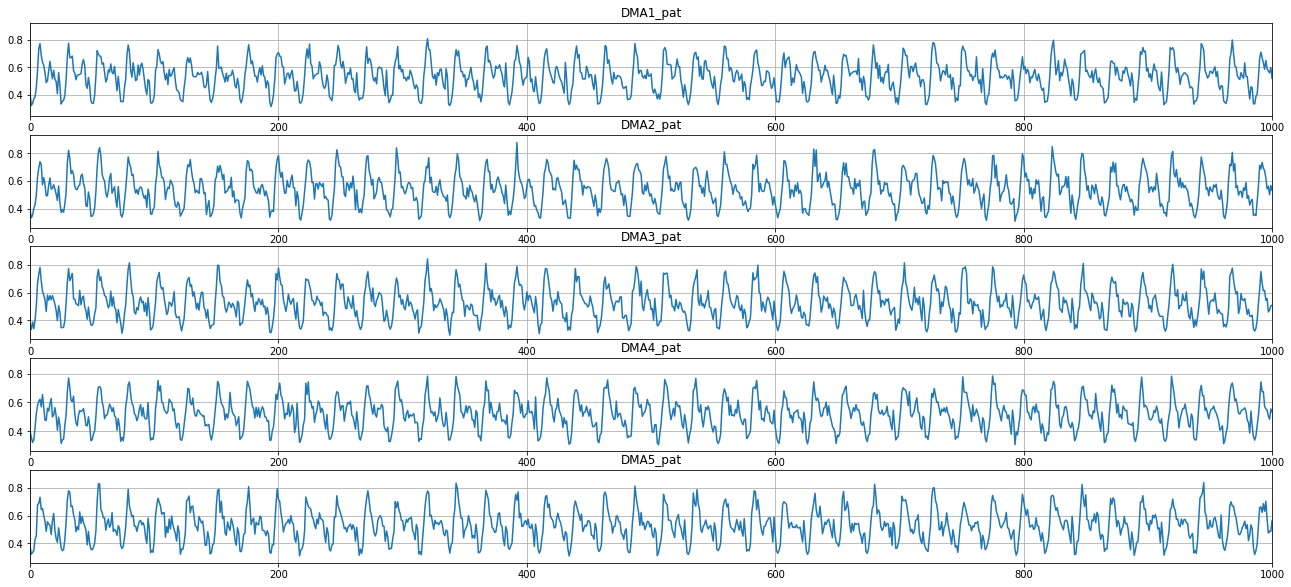

In [6]:
i=1
for pat_name in names:
    dd = plt.subplot(len(names),1,i)
    plt.plot(df_pat_new[pat_name], label="Demand")
    plt.title(pat_name)
    plt.subplots_adjust(top=2.00, right=3.00)
    plt.xlim(left=0, right=1000)
    plt.grid(True)
    i+=1

In [13]:
# Create a pandas dataframe with columns = each DMA pattern and 38 random initial pattern values
values=[]
for i in range(0,38):
    value = random.randint(0, len(df_pat_new)-168)        
    values.append(value)
pattern_random_init_point = pd.DataFrame(data = values)
pattern_random_init_point.columns = ['start']
print(pattern_random_init_point)
pattern_random_init_point.to_csv('starting_demand_points.csv')

    start
0   15464
1    6088
2    1462
3   18262
4   19681
5   24246
6   22135
7   18565
8   12677
9   24667
10  20336
11   7408
12  25258
13   7280
14  15422
15  21993
16   3916
17  21047
18  18583
19   9463
20  11525
21   8008
22  11734
23  21167
24  20244
25  23935
26  21057
27  14326
28   6051
29   2359
30    721
31  14269
32  23949
33  24629
34  16045
35  17418
36  11449
37  22190


In [19]:
# Create a pandas dataframe with initial tank levels for the 7 C-Town tanks and 38 weeks
values=[]
tank_names = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
for name in tank_names:
    aux=[]
    for i in range(0,38):
        tank_max_value = wn.get_node(name).max_level
        min_value = tank_max_value*0.05
        max_value = tank_max_value*0.95
        value = random.uniform(min_value, max_value)        
        aux.append(value)
    values.append(aux)
tank_initial_levels = pd.DataFrame(data = values).T
tank_initial_levels.columns = tank_names
print(tank_initial_levels)
tank_initial_levels.to_csv('tank_initial_conditions.csv')

          T1        T2        T3        T4        T5        T6        T7
0   5.622006  1.373781  2.109871  3.680605  1.466813  1.915251  4.015033
1   5.319035  1.294841  4.277594  3.547004  3.844998  4.195264  1.271854
2   1.229078  1.189771  0.916752  0.749051  3.296872  4.453549  1.344104
3   5.126730  4.433357  1.554679  0.993310  3.305383  2.423245  1.679835
4   0.452680  3.339066  0.701801  2.864921  3.759447  3.008877  2.123344
5   2.660507  2.890578  2.057478  4.422440  1.467856  2.728331  3.061044
6   4.166946  0.669795  0.714426  3.490139  0.495685  1.490854  2.453027
7   4.612390  4.934960  1.640150  1.156455  2.852269  4.695018  2.871224
8   6.059516  0.623743  1.995453  2.351099  0.305070  3.888914  3.733201
9   4.437195  3.262846  1.492698  3.164977  0.993571  1.265600  1.203235
10  1.045673  1.160119  4.652517  2.170569  3.416410  0.609802  2.287600
11  4.012498  0.695165  6.098795  0.422490  2.430622  2.146746  1.016013
12  0.374373  3.371818  0.708938  3.760073  3.20829